In [1]:
# Import Module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 불러오기

In [2]:
train = pd.read_csv('C:/Users/chowonjae/Desktop/data/train.csv')
test = pd.read_csv('C:/Users/chowonjae/Desktop/data/test.csv')

# 데이터 전처리

In [3]:
train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

In [4]:
train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

In [5]:
features = train_img_norm
labels = train_digit.to_numpy()

X_test = test_img_norm

In [6]:
from sklearn.model_selection import train_test_split

validation_split = 0.2

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 1004)

# 필요한 함수 만들기

- createFolder : model을 저장하기 위해 폴더 만들기
- plot_curve : loss, accuracy 그래프 그리기
- create_cnn : cnn을 초기화하는 함수
- train_model_v1, train_model_v2 : train을 위한 함수

In [13]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

In [7]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [8]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(img_input) 
    
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(conv_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('relu')(add_2_1)
    
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(out_2_1)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('relu')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)
    
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_3_0)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('relu')(add_3_1)
    
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(out_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_4_0)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('relu')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = layers.Flatten()(pool_4)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    img_features = layers.Dense(512, activation = 'relu')(img_features)
    img_features = layers.Dropout(rate = 0.5)(img_features)
    
    # Output layer
    digit_pred = layers.Dense(10, activation = 'softmax')(img_features)
    
    model = keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model

In [9]:
def train_model_v1(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = [X_val, y_val], callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = [X_val, y_val], callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

#  모델 Training

- 저는 10개의 모델을 학습한 후에 10개의 출력물을 더하는 방식으로 앙상블을 진행했습니다.
- 훈련은 data를 train_set, val_set 으로 나누어서 먼저 train_set을 학습 시켰으며 train_set으로 학습이 끝난후에는 val_set의 데이터도 학습용으로 사용하기 위해서 val_set을 이용한 학습을 진행하였습니다. (데이터의 양이 적어 val_set도 학습에 포함시켰습니다.)

In [10]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0001)
    model_list.append(model)

***************Trainig_my_model_0*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 204s 124ms/sample - loss: 2.3071 - accuracy: 0.1160 - val_loss: 2.2988 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 204s 124ms/sample - loss: 2.2583 - accuracy: 0.1435 - val_loss: 1.9665 - val_accuracy: 0.3024
Epoch 3/200
1638/1638 [==============================] - 201s 123ms/sample - loss: 1.7492 - accuracy: 0.3932 - val_loss: 1.0253 - val_accuracy: 0.6537
Epoch 4/200
1638/1638 [==============================] - 198s 121ms/sample - loss: 1.0344 - accuracy: 0.6532 - val_loss: 0.7010 - val_accuracy: 0.7561
Epoch 5/200
1638/1638 [==============================] - 202s 124ms/sample - loss: 0.7481 - accuracy: 0.7503 - val_loss: 0.5328 - val_accuracy: 0.8415
Epoch 6/200
1638/1638 [==============================] - 199s 122ms/sample - loss: 0.5377 - accuracy: 0.8248 - val_loss: 0.4880 - val_accuracy: 0.8

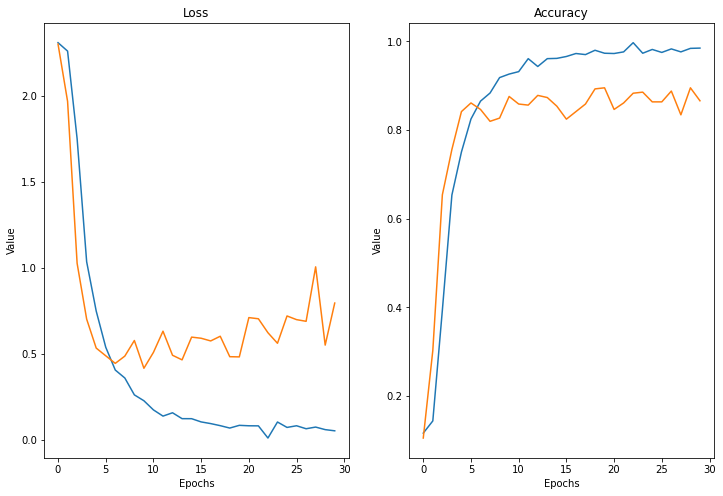

***************Trainig_my_model_1*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 226s 138ms/sample - loss: 2.3073 - accuracy: 0.0952 - val_loss: 2.2959 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 222s 135ms/sample - loss: 2.2205 - accuracy: 0.1661 - val_loss: 1.7736 - val_accuracy: 0.3780
Epoch 3/200
1638/1638 [==============================] - 220s 134ms/sample - loss: 1.5098 - accuracy: 0.4915 - val_loss: 0.9620 - val_accuracy: 0.7122
Epoch 4/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 0.9172 - accuracy: 0.7045 - val_loss: 0.6281 - val_accuracy: 0.7854
Epoch 5/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 0.6293 - accuracy: 0.7918 - val_loss: 0.5659 - val_accuracy: 0.8341
Epoch 6/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 0.4849 - accuracy: 0.8480 - val_loss: 0.4583 - val_accuracy: 0.8

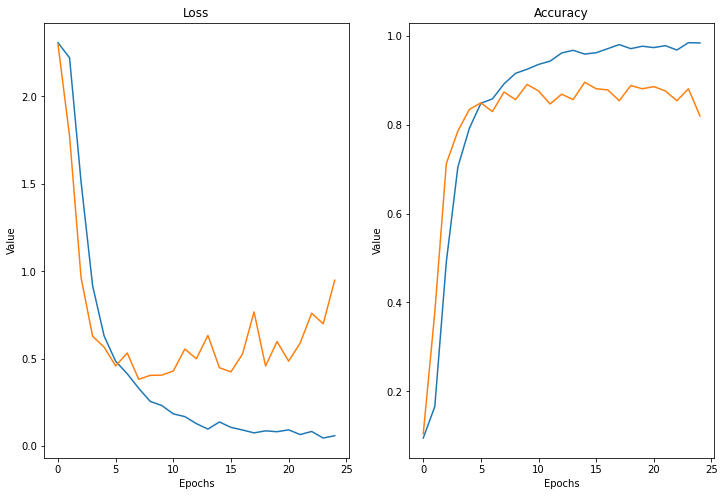

***************Trainig_my_model_2*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 228s 139ms/sample - loss: 2.3067 - accuracy: 0.1136 - val_loss: 2.2954 - val_accuracy: 0.1341
Epoch 2/200
1638/1638 [==============================] - 220s 134ms/sample - loss: 2.1978 - accuracy: 0.1935 - val_loss: 1.8165 - val_accuracy: 0.3463
Epoch 3/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 1.5929 - accuracy: 0.4475 - val_loss: 0.9897 - val_accuracy: 0.7024
Epoch 4/200
1638/1638 [==============================] - 223s 136ms/sample - loss: 0.9519 - accuracy: 0.6880 - val_loss: 0.6718 - val_accuracy: 0.7829
Epoch 5/200
1638/1638 [==============================] - 220s 134ms/sample - loss: 0.6828 - accuracy: 0.7735 - val_loss: 0.5127 - val_accuracy: 0.8488
Epoch 6/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 0.5375 - accuracy: 0.8248 - val_loss: 0.4650 - val_accuracy: 0.8

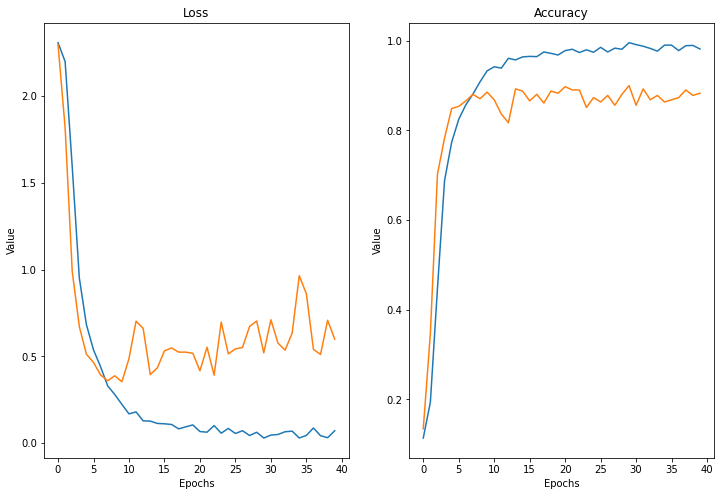

***************Trainig_my_model_3*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 227s 139ms/sample - loss: 2.3086 - accuracy: 0.1093 - val_loss: 2.3002 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 218s 133ms/sample - loss: 2.2957 - accuracy: 0.1172 - val_loss: 2.2367 - val_accuracy: 0.1512
Epoch 3/200
1638/1638 [==============================] - 221s 135ms/sample - loss: 1.9110 - accuracy: 0.3193 - val_loss: 1.2868 - val_accuracy: 0.5902
Epoch 4/200
1638/1638 [==============================] - 199s 121ms/sample - loss: 1.0580 - accuracy: 0.6569 - val_loss: 0.8021 - val_accuracy: 0.7268
Epoch 5/200
1638/1638 [==============================] - 203s 124ms/sample - loss: 0.7194 - accuracy: 0.7619 - val_loss: 0.5330 - val_accuracy: 0.8415
Epoch 6/200
1638/1638 [==============================] - 201s 122ms/sample - loss: 0.5679 - accuracy: 0.8126 - val_loss: 0.5452 - val_accuracy: 0.8

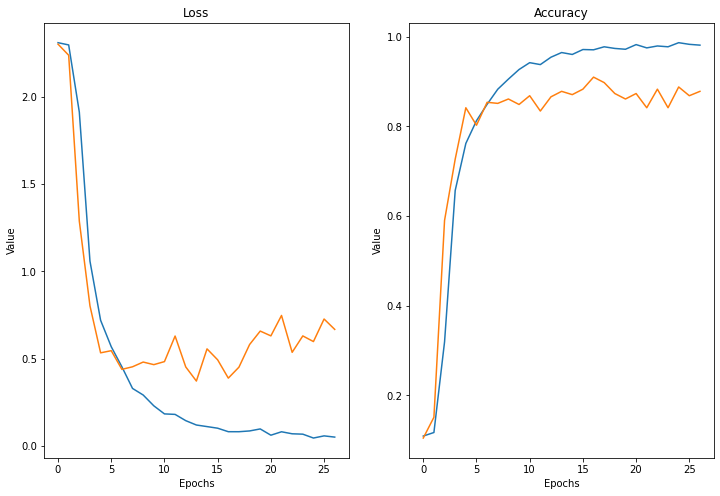

***************Trainig_my_model_4*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 215s 131ms/sample - loss: 2.3063 - accuracy: 0.1093 - val_loss: 2.3024 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 220s 134ms/sample - loss: 2.2741 - accuracy: 0.1337 - val_loss: 2.1097 - val_accuracy: 0.2366
Epoch 3/200
1638/1638 [==============================] - 201s 123ms/sample - loss: 1.7989 - accuracy: 0.3700 - val_loss: 1.1181 - val_accuracy: 0.6268
Epoch 4/200
1638/1638 [==============================] - 202s 124ms/sample - loss: 1.1250 - accuracy: 0.6203 - val_loss: 0.7038 - val_accuracy: 0.7561
Epoch 5/200
1638/1638 [==============================] - 199s 121ms/sample - loss: 0.7383 - accuracy: 0.7454 - val_loss: 0.6403 - val_accuracy: 0.7927
Epoch 6/200
1638/1638 [==============================] - 202s 123ms/sample - loss: 0.5567 - accuracy: 0.8162 - val_loss: 0.6616 - val_accuracy: 0.7

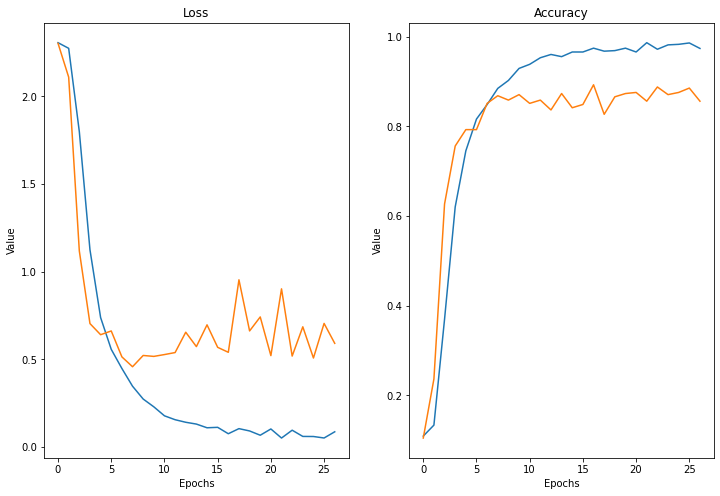

***************Trainig_my_model_5*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 207s 126ms/sample - loss: 2.3087 - accuracy: 0.1074 - val_loss: 2.2998 - val_accuracy: 0.0951
Epoch 2/200
1638/1638 [==============================] - 203s 124ms/sample - loss: 2.2769 - accuracy: 0.1380 - val_loss: 2.0606 - val_accuracy: 0.2756
Epoch 3/200
1638/1638 [==============================] - 200s 122ms/sample - loss: 1.7174 - accuracy: 0.4035 - val_loss: 1.1290 - val_accuracy: 0.6244
Epoch 4/200
1638/1638 [==============================] - 204s 125ms/sample - loss: 0.9690 - accuracy: 0.6832 - val_loss: 0.6381 - val_accuracy: 0.7878
Epoch 5/200
1638/1638 [==============================] - 201s 123ms/sample - loss: 0.6600 - accuracy: 0.7845 - val_loss: 0.5457 - val_accuracy: 0.8195
Epoch 6/200
1638/1638 [==============================] - 200s 122ms/sample - loss: 0.5111 - accuracy: 0.8254 - val_loss: 0.6520 - val_accuracy: 0.7

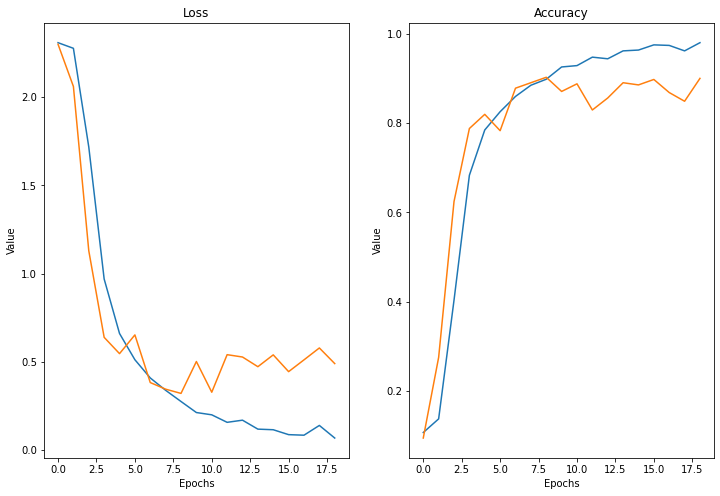

***************Trainig_my_model_6*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 211s 129ms/sample - loss: 2.3077 - accuracy: 0.0995 - val_loss: 2.2969 - val_accuracy: 0.1073
Epoch 2/200
1638/1638 [==============================] - 204s 125ms/sample - loss: 2.1694 - accuracy: 0.1911 - val_loss: 1.8886 - val_accuracy: 0.3268
Epoch 3/200
1638/1638 [==============================] - 204s 124ms/sample - loss: 1.4204 - accuracy: 0.5018 - val_loss: 0.8134 - val_accuracy: 0.7463
Epoch 4/200
1638/1638 [==============================] - 201s 123ms/sample - loss: 0.8549 - accuracy: 0.7344 - val_loss: 0.8785 - val_accuracy: 0.7146
Epoch 5/200
1638/1638 [==============================] - 206s 126ms/sample - loss: 0.6175 - accuracy: 0.7937 - val_loss: 0.4536 - val_accuracy: 0.8488
Epoch 6/200
1638/1638 [==============================] - 203s 124ms/sample - loss: 0.4419 - accuracy: 0.8541 - val_loss: 0.4157 - val_accuracy: 0.8

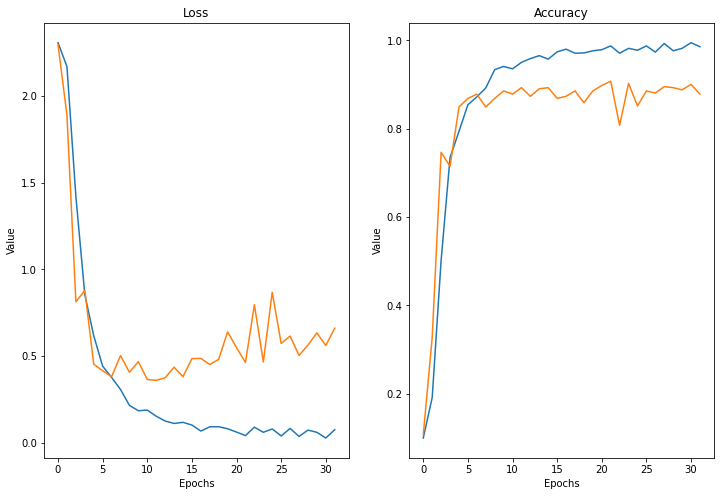

***************Trainig_my_model_7*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 213s 130ms/sample - loss: 2.3072 - accuracy: 0.1050 - val_loss: 2.2998 - val_accuracy: 0.1049
Epoch 2/200
1638/1638 [==============================] - 215s 131ms/sample - loss: 2.2700 - accuracy: 0.1368 - val_loss: 2.0185 - val_accuracy: 0.2390
Epoch 3/200
1638/1638 [==============================] - 208s 127ms/sample - loss: 1.7733 - accuracy: 0.3840 - val_loss: 1.0486 - val_accuracy: 0.6463
Epoch 4/200
1638/1638 [==============================] - 202s 123ms/sample - loss: 1.1149 - accuracy: 0.6337 - val_loss: 0.6845 - val_accuracy: 0.7976
Epoch 5/200
1638/1638 [==============================] - 205s 125ms/sample - loss: 0.7776 - accuracy: 0.7399 - val_loss: 0.5868 - val_accuracy: 0.8000
Epoch 6/200
1638/1638 [==============================] - 204s 125ms/sample - loss: 0.6038 - accuracy: 0.7998 - val_loss: 0.4663 - val_accuracy: 0.8

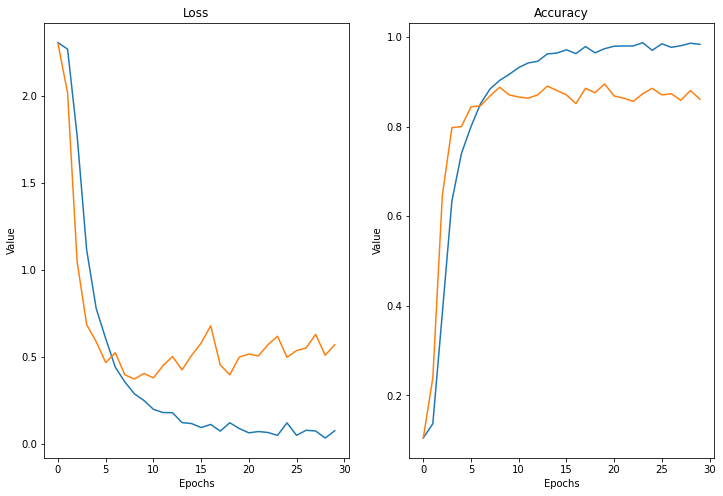

***************Trainig_my_model_8*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 312s 191ms/sample - loss: 2.3053 - accuracy: 0.1190 - val_loss: 2.2972 - val_accuracy: 0.1512
Epoch 2/200
1638/1638 [==============================] - 306s 187ms/sample - loss: 2.1603 - accuracy: 0.2021 - val_loss: 1.7343 - val_accuracy: 0.3829
Epoch 3/200
1638/1638 [==============================] - 312s 190ms/sample - loss: 1.4755 - accuracy: 0.5037 - val_loss: 0.9751 - val_accuracy: 0.6561
Epoch 4/200
1638/1638 [==============================] - 303s 185ms/sample - loss: 0.9432 - accuracy: 0.6990 - val_loss: 0.7194 - val_accuracy: 0.7805
Epoch 5/200
1638/1638 [==============================] - 148s 90ms/sample - loss: 0.6779 - accuracy: 0.7711 - val_loss: 0.4971 - val_accuracy: 0.8220
Epoch 6/200
1638/1638 [==============================] - 148s 90ms/sample - loss: 0.5325 - accuracy: 0.8260 - val_loss: 0.5225 - val_accuracy: 0.829

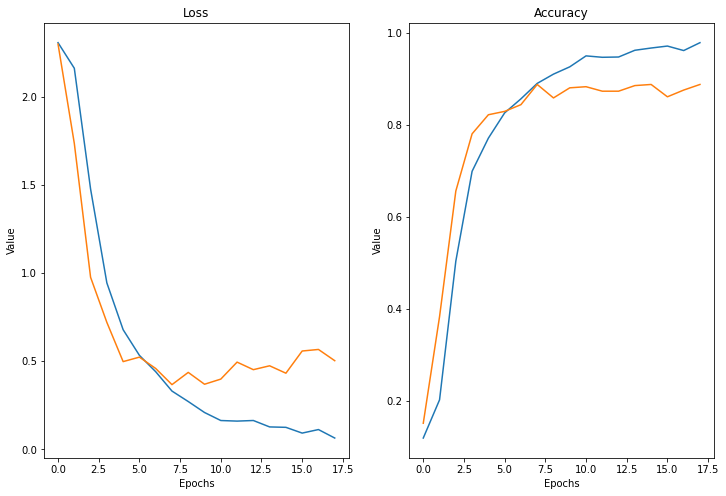

***************Trainig_my_model_9*****************
Train on 1638 samples, validate on 410 samples
Epoch 1/200
1638/1638 [==============================] - 118s 72ms/sample - loss: 2.3077 - accuracy: 0.0983 - val_loss: 2.3017 - val_accuracy: 0.0951
Epoch 2/200
1638/1638 [==============================] - 115s 70ms/sample - loss: 2.2807 - accuracy: 0.1337 - val_loss: 2.0612 - val_accuracy: 0.1927
Epoch 3/200
1638/1638 [==============================] - 115s 70ms/sample - loss: 1.7482 - accuracy: 0.3834 - val_loss: 0.9729 - val_accuracy: 0.7000
Epoch 4/200
1638/1638 [==============================] - 116s 71ms/sample - loss: 0.9937 - accuracy: 0.6722 - val_loss: 0.6315 - val_accuracy: 0.7976
Epoch 5/200
1638/1638 [==============================] - 117s 72ms/sample - loss: 0.6901 - accuracy: 0.7723 - val_loss: 0.5800 - val_accuracy: 0.8146
Epoch 6/200
1638/1638 [==============================] - 117s 72ms/sample - loss: 0.5487 - accuracy: 0.8248 - val_loss: 0.5212 - val_accuracy: 0.8220
Ep

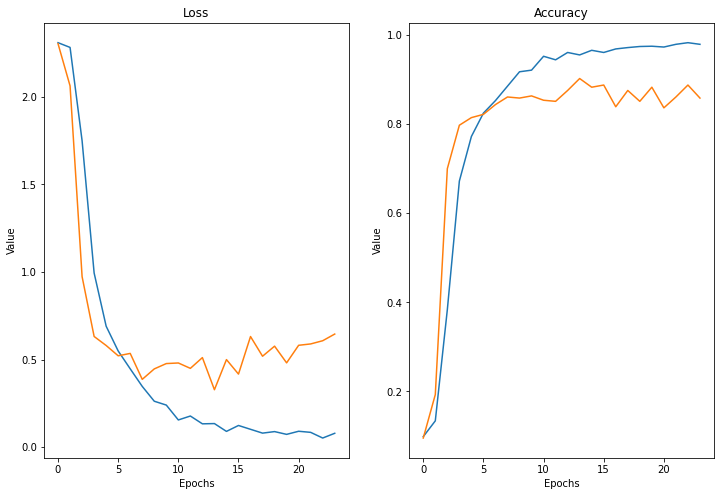

In [11]:
### Training
epochs = 200
batch_size = 1
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], X_train, y_train, X_val, y_val, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [12]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(X_val, y_val)
    result_list.append(result)

************************Evaluating_my_model_0************************
410/410 [==============================] - 4s 9ms/sample - loss: 0.4816 - accuracy: 0.8951
************************Evaluating_my_model_1************************
410/410 [==============================] - 4s 9ms/sample - loss: 0.4482 - accuracy: 0.8951
************************Evaluating_my_model_2************************
410/410 [==============================] - 4s 9ms/sample - loss: 0.5206 - accuracy: 0.9000
************************Evaluating_my_model_3************************
410/410 [==============================] - 3s 9ms/sample - loss: 0.3882 - accuracy: 0.9098
************************Evaluating_my_model_4************************
410/410 [==============================] - 3s 9ms/sample - loss: 0.5399 - accuracy: 0.8927
************************Evaluating_my_model_5************************
410/410 [==============================] - 5s 11ms/sample - loss: 0.3203 - accuracy: 0.9024
************************Evaluatin

In [15]:
pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_model_{}************************".format(i))
    pred = model_list[i].predict(X_test)
    pred_list.append(pred)

************************Predicting_my_model_0************************
************************Predicting_my_model_1************************
************************Predicting_my_model_2************************
************************Predicting_my_model_3************************
************************Predicting_my_model_4************************
************************Predicting_my_model_5************************
************************Predicting_my_model_6************************
************************Predicting_my_model_7************************
************************Predicting_my_model_8************************
************************Predicting_my_model_9************************


In [16]:
pred_df = pd.DataFrame(test["id"])
final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    pred_df['pred{}'.format(i)] = np.argmax(pred_list[i], axis = 1)
    final_pred = final_pred + pred_list[i]

pred_df['final_pred'] = np.argmax(final_pred, axis = 1)

In [17]:
pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,9,9,9,9,9,9,9,9,8,9,9
2,2051,2,2,2,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,8,3,3,8,3,3,3,1,3,3,3


- train_set으로 학습이 끝난 후 val_set으로 다시 학습시켜보았습니다.

In [18]:
re_model_list = []

for i in range(len(model_list)):
    print("************************Loading_my_model_{}************************".format(i))
    my_model = tf.keras.models.load_model('D:/data/CNN 모델/my_model16/model{}'.format(i))
    my_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00001),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    print("************************Re-training_my_model_{}************************".format(i))
    my_model.fit(X_val, y_val, epochs = 5, batch_size = 1)
    
    re_model_list.append(my_model)

************************Loading_my_model_0************************
************************Re-training_my_model_0************************
Train on 410 samples
Epoch 1/5
410/410 [==============================] - 28s 68ms/sample - loss: 0.5250 - accuracy: 0.8805
Epoch 2/5
410/410 [==============================] - 27s 67ms/sample - loss: 0.4427 - accuracy: 0.9024
Epoch 3/5
410/410 [==============================] - 27s 67ms/sample - loss: 0.2551 - accuracy: 0.9220
Epoch 4/5
410/410 [==============================] - 30s 73ms/sample - loss: 0.1889 - accuracy: 0.9341
Epoch 5/5
410/410 [==============================] - 32s 78ms/sample - loss: 0.1390 - accuracy: 0.9488 - l
************************Loading_my_model_1************************
************************Re-training_my_model_1************************
Train on 410 samples
Epoch 1/5
410/410 [==============================] - 32s 79ms/sample - loss: 0.5096 - accuracy: 0.8780
Epoch 2/5
410/410 [==============================] - 30s 73m

In [19]:
# test_set 예측하기

re_pred_list = []

for i in range(len(model_list)):
    print("************************Predicting_my_re_model_{}************************".format(i))
    pred = re_model_list[i].predict(X_test)
    re_pred_list.append(pred)

************************Predicting_my_re_model_0************************
************************Predicting_my_re_model_1************************
************************Predicting_my_re_model_2************************
************************Predicting_my_re_model_3************************
************************Predicting_my_re_model_4************************
************************Predicting_my_re_model_5************************
************************Predicting_my_re_model_6************************
************************Predicting_my_re_model_7************************
************************Predicting_my_re_model_8************************
************************Predicting_my_re_model_9************************


In [21]:
re_pred_df = pd.DataFrame(test["id"])
re_final_pred = np.array([0] * 204800).reshape(20480, 10)

for i in range(len(model_list)):
    re_pred_df['pred{}'.format(i)] = np.argmax(re_pred_list[i], axis = 1)
    re_final_pred = re_final_pred + re_pred_list[i]

re_pred_df['final_pred'] = np.argmax(re_final_pred, axis = 1)

In [22]:
re_pred_df

,id,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,final_pred
0,2049,6,6,6,6,6,6,6,6,6,6,6
1,2050,8,9,9,9,8,9,9,9,9,9,9
2,2051,8,8,8,8,8,8,8,8,8,8,8
3,2052,0,0,0,0,0,0,0,0,0,0,0
4,2053,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,4,4,4,4,4,4,4,4,4,4,4
20476,22525,1,1,1,1,1,1,1,1,1,1,1
20477,22526,6,6,6,6,6,6,6,6,6,6,6
20478,22527,8,3,3,8,3,3,3,3,3,3,3


In [23]:
# 파일 제출
submission = re_pred_df[['id', 'final_pred']].rename(columns = {'final_pred' : 'digit'})
submission.to_csv("transformed_MNIST31.csv", index = False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,3
